# Analysis Bay Area Bike - Udacity Project
## by Sara Vicente

[Project Rubric](https://review.udacity.com/#!/rubrics/1795/view)

**Bay Wheels** offers a fun, easy and inexpensive transportation option for everyone. Bay Wheels stations and bikes are available in the Lyft app throughout San Francisco, East Bay, and San José.

In [this page](https://www.lyft.com/bikes/bay-wheels/system-data) I found the **Bay Wheels travel data** for public use. This data has benn provided in accordance with the Bay Wheels License Agreement.

### Structure of the dataset
The [data](https://s3.amazonaws.com/baywheels-data/index.html) contains several anonymous ride trip made in a bike-sharing system covering the greater San Francisco Bay area. Each of them including:

- **duration_sec:** Trip duration (seconds)
- **start_time:** Start date and time
- **end_time:** End date and time
- **start_station_id:** Identification of the station of departure
- **start_station_name:** Name of departure station
- **start_station_latitude:** Departure station latitude
- **start_station_longitude:** Starting station length
- **end_station_id:** End station identification
- **end_station_name:** End station name
- **end_station_latitude:** End station latitude
- **end_station_longitude:** End station length
- **bike_id:** Identification of the bike
- **user_type:** User type (subscriber or consumer - "Subscriber" = Member or "Consumer" = Casual)
- **member_birth_year:** Member's year of birth
- **member_gender:** Member's gender
- ( * ) bike_share_for_all_trip: No information given

## Preliminary Wrangling

This dataset requires some data wrangling in order to make it tidy for analysis. There are multiple cities covered by the linked system, and multiple data files I will need to be joined together if a full year’s coverage is desired (2018 in my case):


In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure

%matplotlib inline


C:\Users\34616\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
folder_name_of_csvs = 'trip_data_files'

In [7]:
makedirs(folder_name_of_csvs) # makedirs() is recursive directory creation function, makes all intermediate-level directories needed to contain the leaf directory.
for month in range(1,13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2) # zfill() pads string on the left with zeros to fill width.
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [8]:
# Combine All Locally Saved CSVs into One DataFrame
list_csvs = []
for file_name in listdir(folder_name_of_csvs):
    list_csvs.append(pd.read_csv(folder_name_of_csvs+'/'+file_name))
df = pd.concat(list_csvs)

In [10]:
# Save data to a csv archive
df.to_csv('data.csv')

In [11]:
# Read DataFrame
rides_18 = pd.read_csv('data.csv')

In [12]:
rides_18.shape

(1863721, 17)

In [13]:
rides_18.head(2)

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No
1,1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No


In [14]:
# Generate minutes for trip duration from duration_sec
rides_18['duration_hour'] = rides_18['duration_sec']/3600

In [15]:
# Set dates to timestamps
rides_18.start_time = pd.to_datetime(rides_18.start_time)
rides_18.end_time = pd.to_datetime(rides_18.end_time)
# Set user type, gender and bike_share_for_all_trip to category
rides_18.user_type = rides_18.user_type.astype('category')
rides_18.member_gender = rides_18.member_gender.astype('category')
rides_18.bike_share_for_all_trip = rides_18.bike_share_for_all_trip.astype('category')
# Set bike id, start_station_id, end_station_id to object
rides_18.bike_id = rides_18.bike_id.astype(str)
rides_18.start_station_id = rides_18.start_station_id.astype(str)
rides_18.end_station_id = rides_18.end_station_id.astype(str)

In [16]:
# Extract start time month name
rides_18['startTime_month']=rides_18['start_time'].dt.strftime('%B')
# Extract start time month number
rides_18['startTime_date']=rides_18['start_time'].dt.date
# Extract start time weekdays
rides_18['startTime_weekday']=rides_18['start_time'].dt.strftime('%a')
# Extract start time day
rides_18['startTime_day']=rides_18['start_time'].dt.day.astype(int)
# extract start time hour
rides_18['startTime_hour']=rides_18['start_time'].dt.hour
# extract start time quarter
rides_18['startTime_quarter']=rides_18['start_time'].dt.quarter

In [17]:
rides_18.sample(5)

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,...,member_birth_year,member_gender,bike_share_for_all_trip,duration_hour,startTime_month,startTime_date,startTime_weekday,startTime_day,startTime_hour,startTime_quarter
1232986,22438,505,2018-09-27 08:25:44.587,2018-09-27 08:34:09.903,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,102.0,Irwin St at 8th St,...,1963.0,Female,No,0.140278,September,2018-09-27,Thu,27,8,3
1427333,30568,2703,2018-10-26 17:35:57.894,2018-10-26 18:21:01.660,152.0,47th St at San Pablo Ave,37.835632,-122.281051,152.0,47th St at San Pablo Ave,...,1982.0,Male,No,0.750833,October,2018-10-26,Fri,26,17,4
110973,16171,181,2018-02-23 21:08:06.703,2018-02-23 21:11:08.372,243.0,Bancroft Way at College Ave,37.869360,-122.254337,247.0,Fulton St at Bancroft Way,...,1991.0,Male,No,0.050278,February,2018-02-23,Fri,23,21,1
1533762,136997,1067,2018-10-10 14:32:06.429,2018-10-10 14:49:53.888,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,120.0,Mission Dolores Park,...,1983.0,Male,No,0.296389,October,2018-10-10,Wed,10,14,4
437130,124228,1007,2018-04-02 19:38:02.098,2018-04-02 19:54:49.776,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,67.0,San Francisco Caltrain Station 2 (Townsend St...,...,1983.0,Other,No,0.279722,April,2018-04-02,Mon,2,19,2


As the data frame contains rides from various cities that fall within the Bay Area, such as San José or Oakland, I have decided to eliminate these as I consider that the rides between these cities and San Francisco are not common and I want to focus my analysis on the city of San Francisco only. Therefore, I am going to filter the data by the following coordinates:

**San Francisco City and County Map Boundary Limits**

- Latitude at top edge of map, in decimal degrees
> top = 37.815497
- Latitude at bottom edge of map, in decimal degrees
> bottom = 37.705553
- Longitude at left edge of map, in decimal degrees
> left = -122.575294
- Longitude at right edge of map, in decimal degrees
> right = -122.281663

*Source: [Latitude and Longitude Finder](https://www.latlong.net/)*

In [18]:
# Define coordinate limits for San Francisco City and County 
top_lat = 37.815497 
bottom_lat = 37.705553
left_long = -122.575294
right_long = -122.281663

# Create latitude and longitude masks start station:
start_station_lat_limits = (rides_18['start_station_latitude'] >= bottom_lat) & (rides_18['start_station_latitude'] <= top_lat) 
start_station_long_limits = (rides_18['start_station_longitude'] >= left_long) & (rides_18['start_station_longitude'] <= right_long)

# Create latitude and longitude masks end station:
end_station_lat_limits = (rides_18['end_station_latitude'] >= bottom_lat) & (rides_18['end_station_latitude'] <= top_lat)
end_station_long_limits =(rides_18['end_station_longitude'] >= left_long) & (rides_18['end_station_longitude'] <= right_long)

# Remove from the dataframe rides that fall outside the San Francisco City and County area
rides_18 = rides_18[end_station_lat_limits & start_station_lat_limits & end_station_long_limits & start_station_long_limits]

In [19]:
rides_18.shape

(1371833, 24)

In [20]:
# Drop unnecessary columns for the analysis
rides_18.drop(['Unnamed: 0','duration_sec','start_station_id',
               'start_station_latitude','start_station_longitude','end_station_id',
               'end_station_latitude','end_station_longitude','bike_share_for_all_trip'], axis=1, inplace=True)

In [21]:
# Convert member_birth_year to member_age
rides_18['member_age'] = 2018 - rides_18['member_birth_year']
# Drop member_birth_year column
rides_18.drop(['member_birth_year'], axis=1, inplace=True)

In [22]:
# Check max member age
rides_18.member_age.max()

137.0

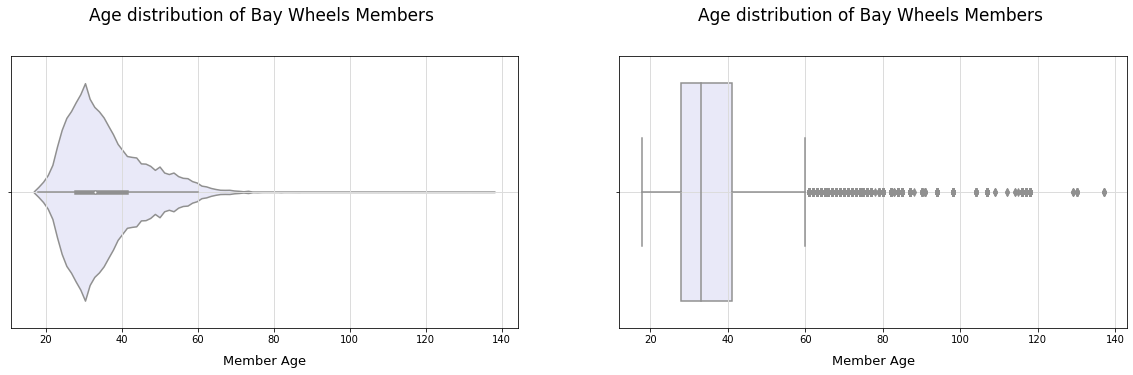

In [23]:
# Plot age distribution 
plt.figure(figsize=(20,5))

plt.subplot(121)
sb.violinplot(data=rides_18, x='member_age', color='lavender')
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title("Age distribution of Bay Wheels Members \n", fontsize=17, y=1.03)
plt.xlabel("Member Age", fontsize=13, labelpad=10);

plt.subplot(122)
sb.boxplot(data=rides_18, x='member_age', color='lavender')
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title("Age distribution of Bay Wheels Members \n", fontsize=17, y=1.03)
plt.xlabel("Member Age", fontsize=13, labelpad=10);

In [24]:
perc_older60 = (len(rides_18[rides_18['member_age']>=60])/len(rides_18))*100
Age_mean = rides_18.member_age.mean()

print('Percentage of members older than 60:', perc_older60,'%')
print('Age mean:', Age_mean)

Percentage of members older than 60: 2.2749853662945854 %
Age mean: 35.40459754525287


Based on the plot, it looks like members around 35 years old represent the vast majority and those older than 60 do not represent the norm, being these last identified as outliers (see box plot), also, there are members older than 100, which might be an error. Therefore, I have decided to remove those older than 60 for my analysis (they only represented 2.27%)

In [25]:
# Remove members those older than 60
rides_18 = rides_18[rides_18['member_age']<=60]

In [26]:
rides_18.head()

,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_gender,duration_hour,startTime_month,startTime_date,startTime_weekday,startTime_day,startTime_hour,startTime_quarter,member_age
0,2018-01-31 22:52:35.239,2018-02-01 19:47:19.824,Mission Dolores Park,Webster St at O'Farrell St,2765,Subscriber,Male,20.912222,January,2018-01-31,Wed,31,22,1,32.0
4,2018-01-31 19:52:24.667,2018-02-01 06:58:31.053,Laguna St at Hayes St,Post St at Kearny St,617,Subscriber,Male,11.101667,January,2018-01-31,Wed,31,19,1,27.0
6,2018-01-31 23:53:53.632,2018-02-01 00:01:26.805,17th & Folsom Street Park (17th St at Folsom St),Valencia St at 24th St,3571,Subscriber,Male,0.125833,January,2018-01-31,Wed,31,23,1,30.0
7,2018-01-31 23:52:09.903,2018-01-31 23:55:10.807,Berry St at 4th St,4th St at Mission Bay Blvd S,1403,Subscriber,Male,0.050000,January,2018-01-31,Wed,31,23,1,38.0
8,2018-01-31 23:34:56.004,2018-01-31 23:51:32.674,Valencia St at 24th St,Cyril Magnin St at Ellis St,3675,Subscriber,Male,0.276667,January,2018-01-31,Wed,31,23,1,31.0


In [27]:
print('Number of unique bikes:', len(rides_18.bike_id.value_counts()))
print('Number of unique stations:', len(rides_18.start_station_name.value_counts()))
print('Maximum ride duration:', rides_18.duration_hour.max(), 'hours')
print('Minimum ride duration:', (rides_18.duration_hour.min())*60,'mins')
print('Maximum age:', rides_18.member_age.max(), 'years old')
print('Minimum age:', rides_18.member_age.min(),'years old')

Number of unique bikes: 4361
Number of unique stations: 165
Maximum ride duration: 23.966944444444444 hours
Minimum ride duration: 1.0166666666666668 mins
Maximum age: 60.0 years old
Minimum age: 18.0 years old


In [28]:
# Create bins for members' age into a new column
bins = [10, 20, 30, 40, 50, 60]
rides_18['Age_range'] = pd.cut(rides_18['member_age'], bins)
rides_18.Age_range.value_counts()

(30, 40]    471756
(20, 30]    466346
(40, 50]    200064
(50, 60]    100080
(10, 20]     19503
Name: Age_range, dtype: int64

In [29]:
# Create a function to extract the season out of the date column
"""
def season_of_date(date):
    Y = "2018"
    seasons = {'spring': pd.date_range(start='21/03/'+Y, end='20/06/'+Y),
               'summer': pd.date_range(start='21/06/'+Y, end='22/09/'+Y),
               'autumn': pd.date_range(start='23/09/'+Y, end='20/12/'+Y)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

# Apply function to startTime_date column creating a new season column
rides_18['season'] = rides_18.startTime_date.map(season_of_date)
"""
# I had to stop the kernel as it was taking too long due to the volume of the dataframe

'\ndef season_of_date(date):\n    Y = "2018"\n    seasons = {\'spring\': pd.date_range(start=\'21/03/\'+Y, end=\'20/06/\'+Y),\n               \'summer\': pd.date_range(start=\'21/06/\'+Y, end=\'22/09/\'+Y),\n               \'autumn\': pd.date_range(start=\'23/09/\'+Y, end=\'20/12/\'+Y)}\n    if date in seasons[\'spring\']:\n        return \'spring\'\n    if date in seasons[\'summer\']:\n        return \'summer\'\n    if date in seasons[\'autumn\']:\n        return \'autumn\'\n    else:\n        return \'winter\'\n\n# Apply function to startTime_date column creating a new season column\nrides_18[\'season\'] = rides_18.startTime_date.map(season_of_date)\n'

In [30]:
# Check if any of columns have null values
rides_18.isnull().sum().any()

False

In [31]:
rides_18.duration_hour.min(),rides_18.duration_hour.max()

(0.016944444444444446, 23.966944444444444)

In [220]:
# Create bins for ride duration (in hours) into a new column
bins_ = [0, 1, 4, 10, 24]
rides_18['duration_hour_range'] = pd.cut(rides_18['duration_hour'], bins_)
rides_18.duration_hour_range.value_counts()

(0, 1]      1243617
(1, 4]        11705
(4, 10]        1500
(10, 24]        927
Name: duration_hour_range, dtype: int64

In [221]:
# Save data to a csv archive
rides_18.to_csv('rides_18.csv')

# Ford GoBike Data Analysis for the City of San Francisco in 2018


The cleaned dataset contains the columns of interest for the analysis. This new dataset of interest comprises of 16 columns and 1257749 records archived in **'rides_18.csv'** file. 

The new **features** of the ***rides_18_clean*** dataframe are:
          
   - start_time
   - end_time
   - start_station_name   
   - end_station_name     
   - bike_id             
   - user_type             
   - member_gender        
   - duration_hour        
   - startTime_month      
   - startTime_date       
   - startTime_weekday    
   - startTime_day        
   - startTime_hour        
   - member_age           
   - Age_range            
   - duration_hour_range
   
### My main features of interest in the dataset

- **Distribution of rides throughout** different **time** associations to improve availability and reduce costs.
- **Associations** between **users age and the different features** oriented to a future marketing strategy.
- **Associations** between **users type and the different features** for future promotion strategies.
- **Most/less popular stations** to improve the logistic of bikes distribution and maybe eliminate or onclude more station points.


In [3]:
# Read the DataFrame
rides_18_clean = pd.read_csv('rides_18.csv')
rides_18_clean.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
# I will not need start_time and end_time variables, therefore, I am going to drop them from the dataset
rides_18_clean.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [5]:
rides_18_clean.head()

,start_station_name,end_station_name,bike_id,user_type,member_gender,duration_hour,startTime_month,startTime_date,startTime_weekday,startTime_day,startTime_hour,startTime_quarter,member_age,Age_range,duration_hour_range
0,Mission Dolores Park,Webster St at O'Farrell St,2765,Subscriber,Male,20.912222,January,2018-01-31,Wed,31,22,1,32.0,"(30, 40]","(10, 24]"
1,Laguna St at Hayes St,Post St at Kearny St,617,Subscriber,Male,11.101667,January,2018-01-31,Wed,31,19,1,27.0,"(20, 30]","(10, 24]"
2,17th & Folsom Street Park (17th St at Folsom St),Valencia St at 24th St,3571,Subscriber,Male,0.125833,January,2018-01-31,Wed,31,23,1,30.0,"(20, 30]","(0, 1]"
3,Berry St at 4th St,4th St at Mission Bay Blvd S,1403,Subscriber,Male,0.050000,January,2018-01-31,Wed,31,23,1,38.0,"(30, 40]","(0, 1]"
4,Valencia St at 24th St,Cyril Magnin St at Ellis St,3675,Subscriber,Male,0.276667,January,2018-01-31,Wed,31,23,1,31.0,"(30, 40]","(0, 1]"


## Univariate Exploration

> In this section, I investigate the trend of some variables in the data. Univariate exploration is necessary to determine the trend of the individual variables of the dataset you are working with. This initial study not only helps visualize trends, but allows determining outliers and points outside the norm.



### Quearterly rides trend over 2018

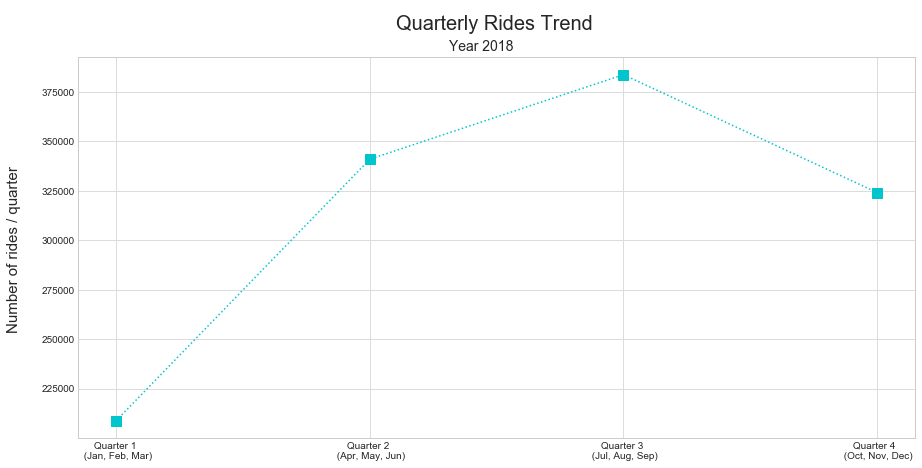

In [6]:
plt.style.use("seaborn-whitegrid")
rides_18_clean.groupby('startTime_quarter').agg({'startTime_quarter':'count'}).plot(style=':',
                                                                                    legend=False,
                                                                                    figsize=(15,7), 
color='#00C5CD', marker='s',ms=10, linewidth=1.5)
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('Quarterly Rides Trend \n', fontsize=20)
plt.suptitle('\n\nYear 2018 \n',fontsize=14)
plt.ylabel('Number of rides / quarter \n', fontsize=15)
plt.xlabel('Quarter of the year').set_visible(False)

x_ticks = [1, 2, 3, 4]
x_ticks_labels = ["Quarter 1 \n (Jan, Feb, Mar)","Quarter 2 \n (Apr, May, Jun)",
                  "Quarter 3 \n (Jul, Aug, Sep)", "Quarter 4  \n (Oct, Nov, Dec)"]
plt.xticks(x_ticks,x_ticks_labels);

The **third quarter of the year is the one with the highest number of rides** (these are the most touristy months and with nicer weather), followed by the second and fourth, with an **appreciable decline in the number of rides during the first quarter of the year**, probably due to colder weather.

### Daily rides trend over 2018

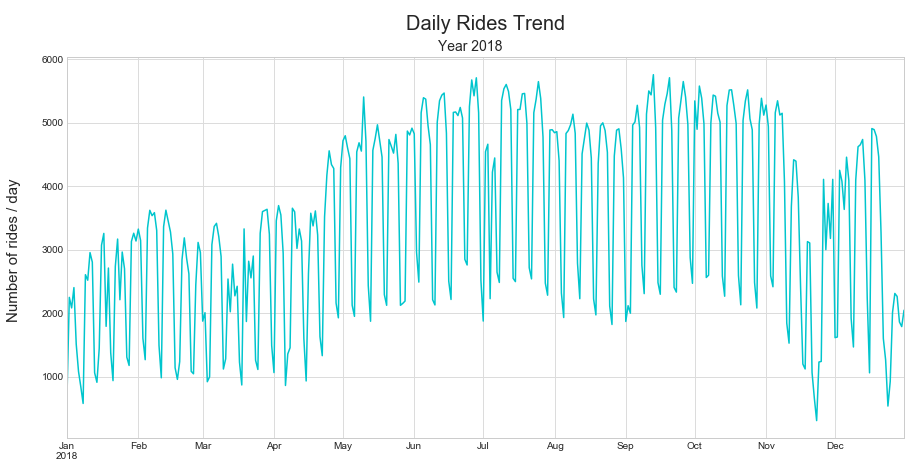

In [7]:
import matplotlib.ticker as tick

rides_18_clean.startTime_date = pd.to_datetime(rides_18_clean['startTime_date'], format='%Y-%m-%d %H:%M:%S.%f')

plt.style.use("seaborn-whitegrid")
rides_18_clean.groupby('startTime_date').agg({'bike_id':'count'}).plot(style='-',
                                                                       legend=False,
                                                                       figsize=(15,7),
                                                                       color='#00C5CD')
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('Daily Rides Trend\n', fontsize=20)
plt.suptitle('\n\nYear 2018 \n',fontsize=14)
plt.ylabel('Number of rides / day \n', fontsize=15)
plt.xlabel('Month (2018)').set_visible(False);

We could say how, in this plot, the daily trend has a very high frequency, varying strongly throughout the month, with peaks of maximums and minimuns of at least four times a month evenly distributed. This makes us think that it is because **on weekends the Number of riders declines sharply.**

The trend also differs over the months, **rides are more popular between  May and October.** With a sharp decline in late November and December.

### Weekly rides trend over 2018

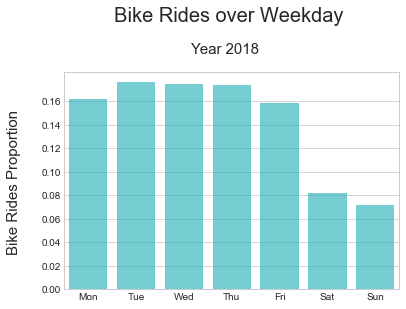

In [8]:
# Set the order for the startTime_weekday variables
ordinal_var = ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun']
pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var)
    rides_18_clean['startTime_weekday'] = rides_18_clean['startTime_weekday'].astype(ordered_var)
else: # pre-v0.21
    rides_18_clean['startTime_weekday'] = rides_18_clean['startTime_weekday'].astype('category', ordered = True, categories = ordinal_var)


# get proportion taken by most common group for derivation of tick marks
n_points = rides_18_clean.shape[0]
max_count = rides_18_clean['startTime_weekday'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.02)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
plt.yticks(tick_props * n_points, tick_names)

# Create the plot
plt.style.use("seaborn-whitegrid")
color = '#00C5CD'
sb.countplot(data = rides_18_clean, x = 'startTime_weekday', color = color, alpha=.6)
plt.title('Bike Rides over Weekday \n\n ', fontsize=20)
plt.suptitle('Year 2018 \n',fontsize=15)
plt.ylabel('Bike Rides Proportion \n', fontsize=15)
plt.xlabel('Weekday').set_visible(False);

Indeed, as could be appreciated from the previous plot, the **number of rides falls almost 50% during the weekends.**  **Tuesday** is the **most popular day for riders**, closely followed by Wednesday and Thursday.

### Hourly rides trend over 2018

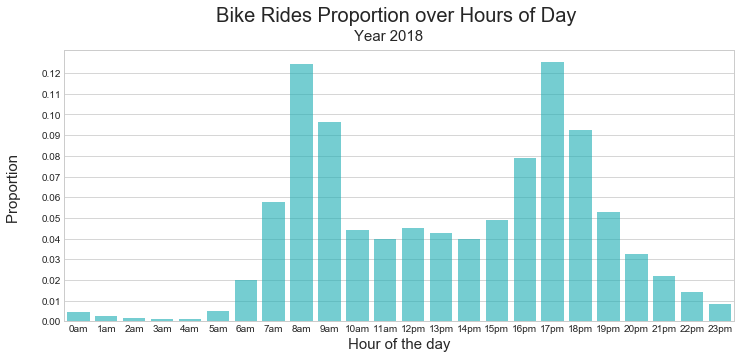

In [9]:
# Create the plot
plt.style.use("seaborn-whitegrid")
color = '#00C5CD'
plt.figure(figsize=(12,5))
sb.countplot(data = rides_18_clean, x = 'startTime_hour', color = color, alpha=.6)
plt.title('Bike Rides Proportion over Hours of Day \n', fontsize=20)
plt.suptitle('\n Year 2018 \n',fontsize=15)
plt.ylabel('Proportion \n', fontsize=15)
plt.xlabel('Hour of the day', fontsize=15)

# get proportion taken by most common group for derivation of tick marks
n_points = rides_18_clean.shape[0]
max_count = rides_18_clean['startTime_hour'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.01)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
plt.yticks(tick_props * n_points, tick_names)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am", "12pm",
                  "13pm", "14pm", "15pm", "16pm", "17pm", "18pm", "19pm", "20pm", "21pm", "22pm", "23pm"]
plt.xticks(x_ticks,x_ticks_labels);

In general, there are two ride start hour peaks throughout the day, these are at **8 in the morning** and at **5 in the afternoon.** after 5pm, the trend declines continuously. Rides are very unusual during the early morning hours, as expected.

### Bike Rides Duration Ranges

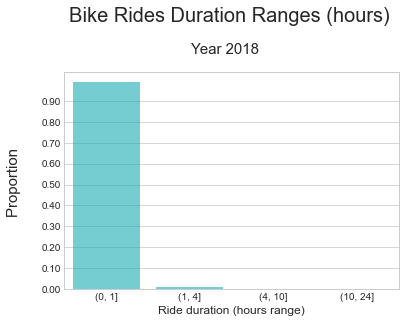

In [10]:
# Set the order for the startTime_weekday variables
ordinal_var = ['(0, 1]', '(1, 4]', '(4, 10]', '(10, 24]']
pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var)
    rides_18_clean['duration_hour_range'] = rides_18_clean['duration_hour_range'].astype(ordered_var)
else: # pre-v0.21
    rides_18_clean['duration_hour_range'] = rides_18_clean['duration_hour_range'].astype('category', ordered = True, categories = ordinal_var)

# Create the plot
plt.style.use("seaborn-whitegrid")
color = '#00C5CD'
sb.countplot(data = rides_18_clean, x = 'duration_hour_range', color = color, alpha=.6)
plt.title('Bike Rides Duration Ranges (hours) \n \n ', fontsize=20)
plt.suptitle('Year 2018 \n',fontsize=15)
plt.ylabel('Proportion \n', fontsize=15)
plt.xlabel('Ride duration (hours range)', fontsize=12)

# get proportion taken by most common group for derivation of tick marks
n_points = rides_18_clean.shape[0]
max_count = rides_18_clean['duration_hour_range'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.1)
tick_names = ['0-1 h','1-4 h','4-10 h','10-24 h']
plt.yticks(tick_props * n_points, tick_names);

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.1)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
plt.yticks(tick_props * n_points, tick_names);

It is curious how **more than 95% of rides** throughout the year last **less than an hour.**

### Rides proportion per Age ranges

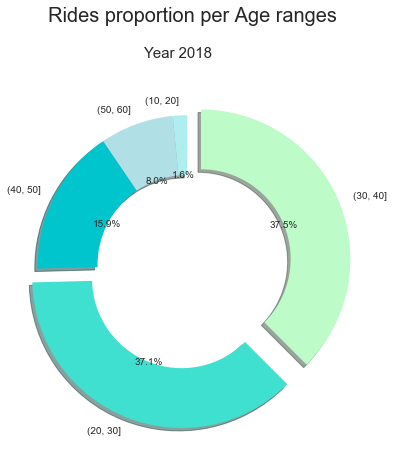

In [11]:
# Age range plot
plt.figure(figsize = [15, 6.5])
plt.subplot(1, 1, 1)
colors = ['#BDFCC9','#40E0D0','#00C5CD', '#B0E0E6', '#AEEEEE']
explode = (0.1, 0.1, 0, 0, 0)
sorted_counts = rides_18_clean['Age_range'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.4},
       colors=colors, shadow=True, explode=explode, autopct='%1.1f%%')
plt.axis('square')
plt.title('Rides proportion per Age ranges\n\n\n', fontsize=20)
plt.suptitle('Year 2018 \n',fontsize=15);

I have decided to extract the age of users by ranges of 10 years, from 11 to 60 years. It can be easily seen that the most represented age ranges over the year 2018 are riders from **31 - 40 years old (37.5%)** and riders from **21 - 30 years old (37.1%)**, followed by people from 41 - 50 years and from 51 - 60, with a minimum representation (of only 1.6%) of young people between 11 and 20 years.

### Rides proportion per Gender and User Type

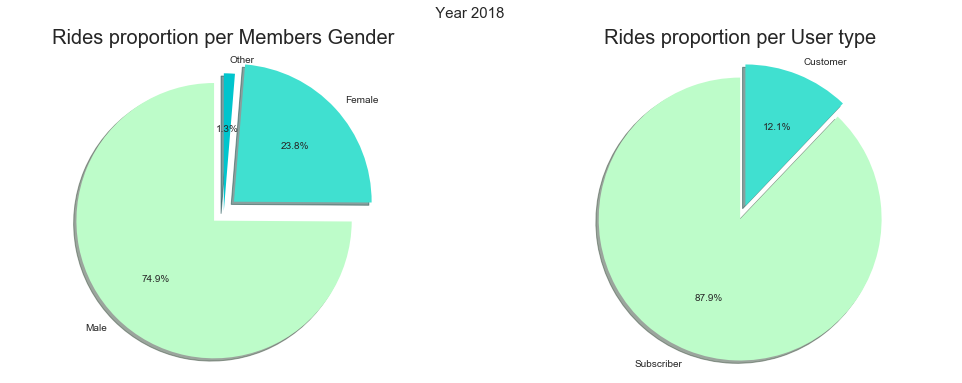

In [12]:
### Rides proportion per Age ranges# univariate plots of gender and user type
plt.figure(figsize = [17, 6])

# Gender plot
labels = ['Male', 'Female', 'Other']
sizes = rides_18_clean['member_gender'].value_counts()
explode = (0.1, 0.1, 0) # only "explode" the male and female up slice

plt.subplot(1, 2, 1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal'); # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Rides proportion per Members Gender', fontsize=20)
plt.suptitle('    Year 2018 \n',fontsize=15);

# User type plot
labels2 = ['Subscriber', 'Customer']
sizes = rides_18_clean['user_type'].value_counts()
explode = (0, 0.1) 

plt.subplot(1, 2, 2)
plt.pie(sizes, explode=explode, labels=labels2, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal'); # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Rides proportion per User type', fontsize=20)
plt.suptitle('   Year 2018 \n',fontsize=15);

**Users Gender**
Over the year 2018, male users represent almost three-quarters of all users, with the female group representing 23.8% of them. 1.3% of users have preferred not to share their sex or simply identify with a Third gender, this is a concept in which individuals are categorized, either by themselves or by society, as neither man nor woman.

**Users Type**
The proportion of subscribers is 87.9%, very high compared to 12.1% represented by Customers.

In short, the **most popular users** are **male subscribers.**

### Start & End Stations Ranking in 2018

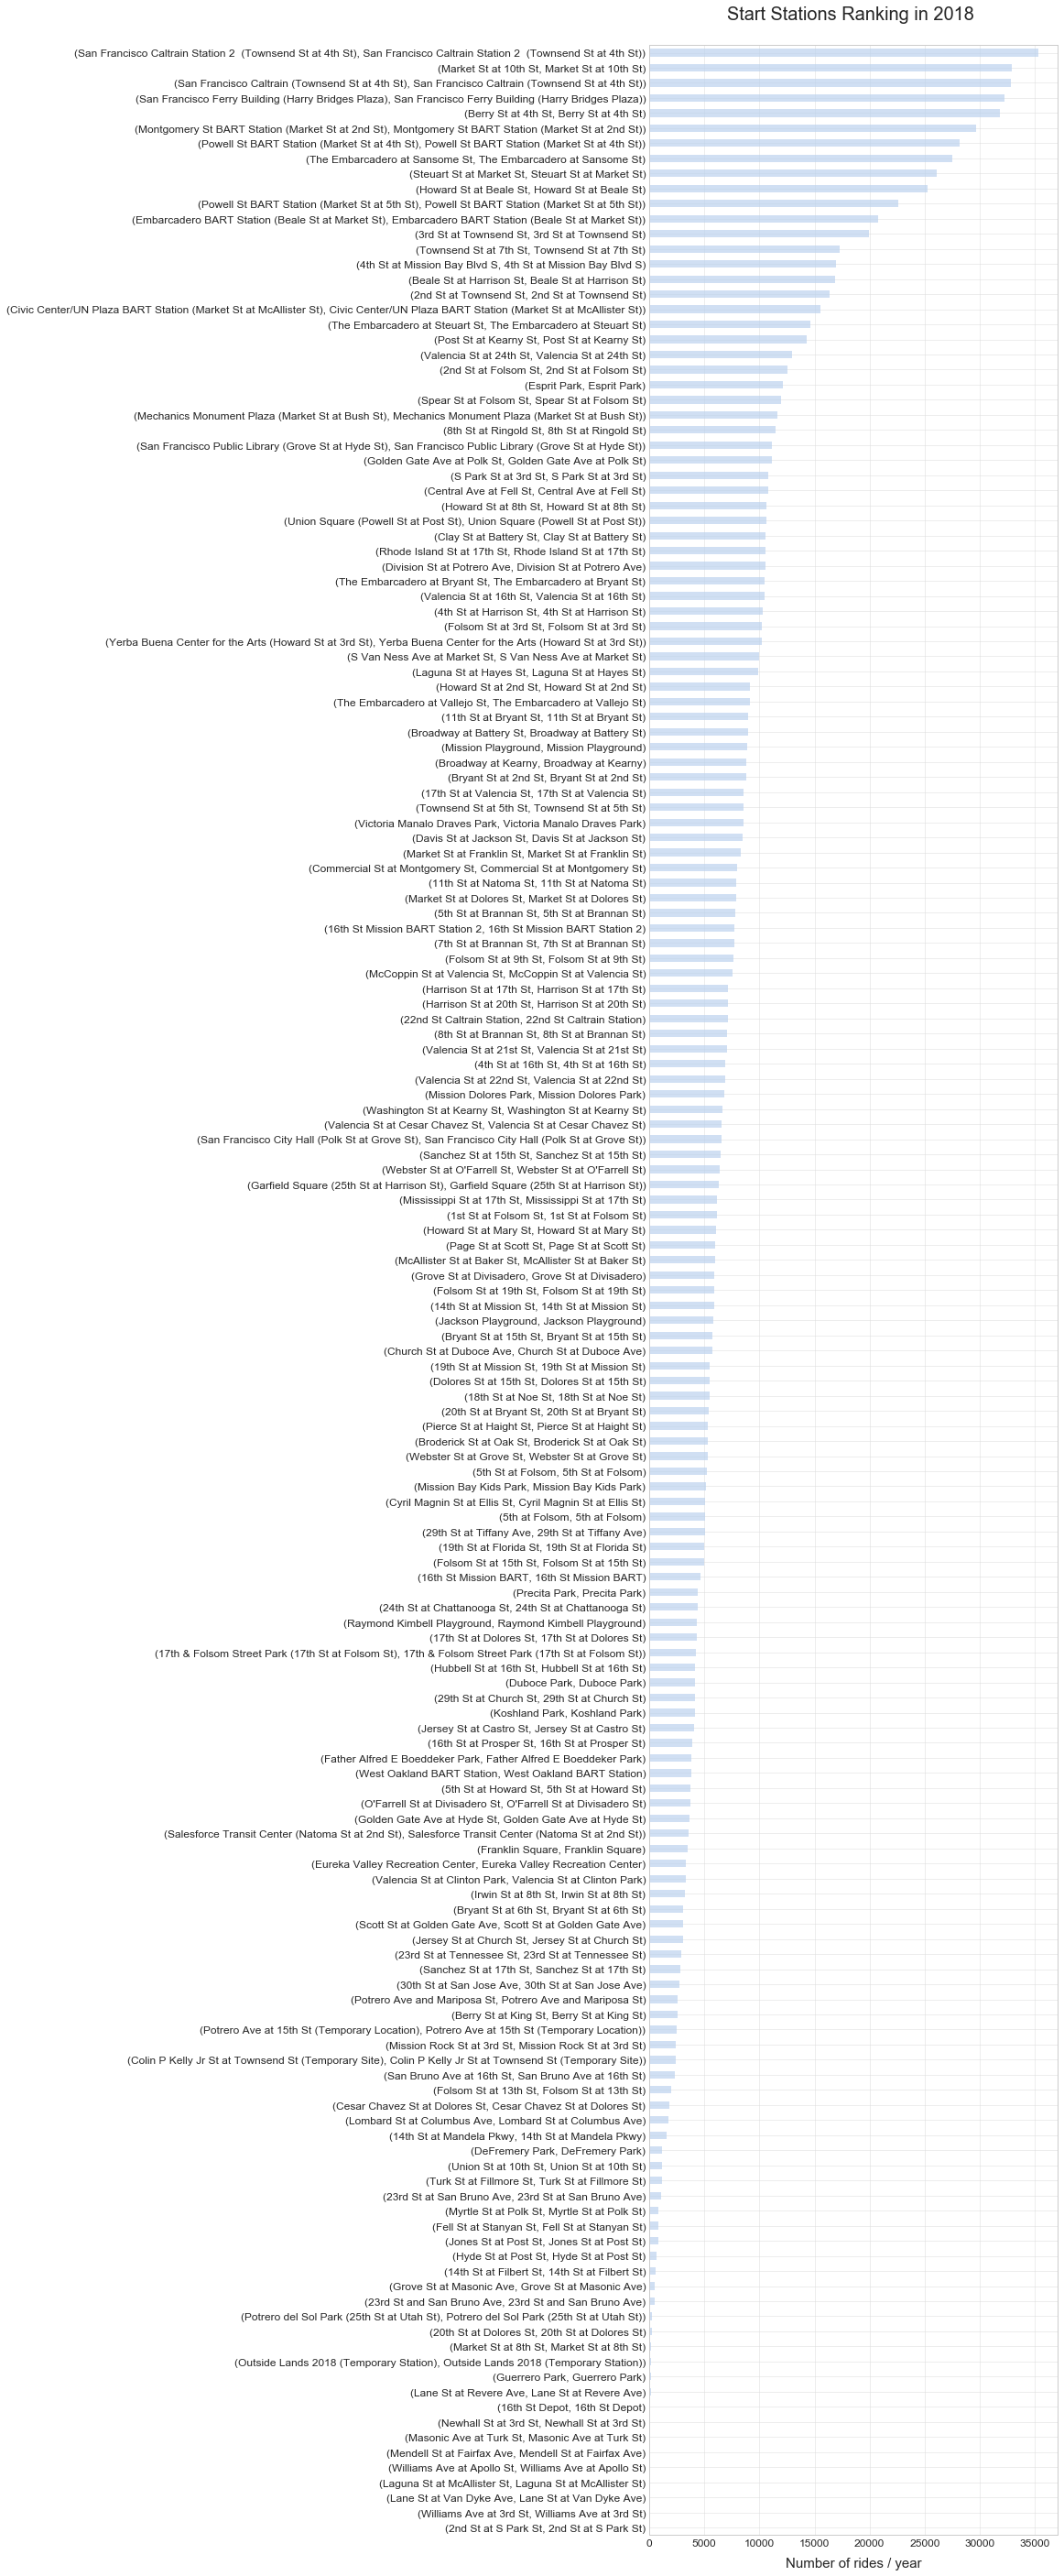

In [13]:
### Rides proportion per Age ranges# plot Ranking start stations
data=rides_18_clean.groupby('start_station_name')
data['start_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, 
                                                             color = '#BCD2EE',figsize = [8,50],
                                                             alpha=0.7)
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Start Stations Ranking in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("Start Station Name").set_visible(False);

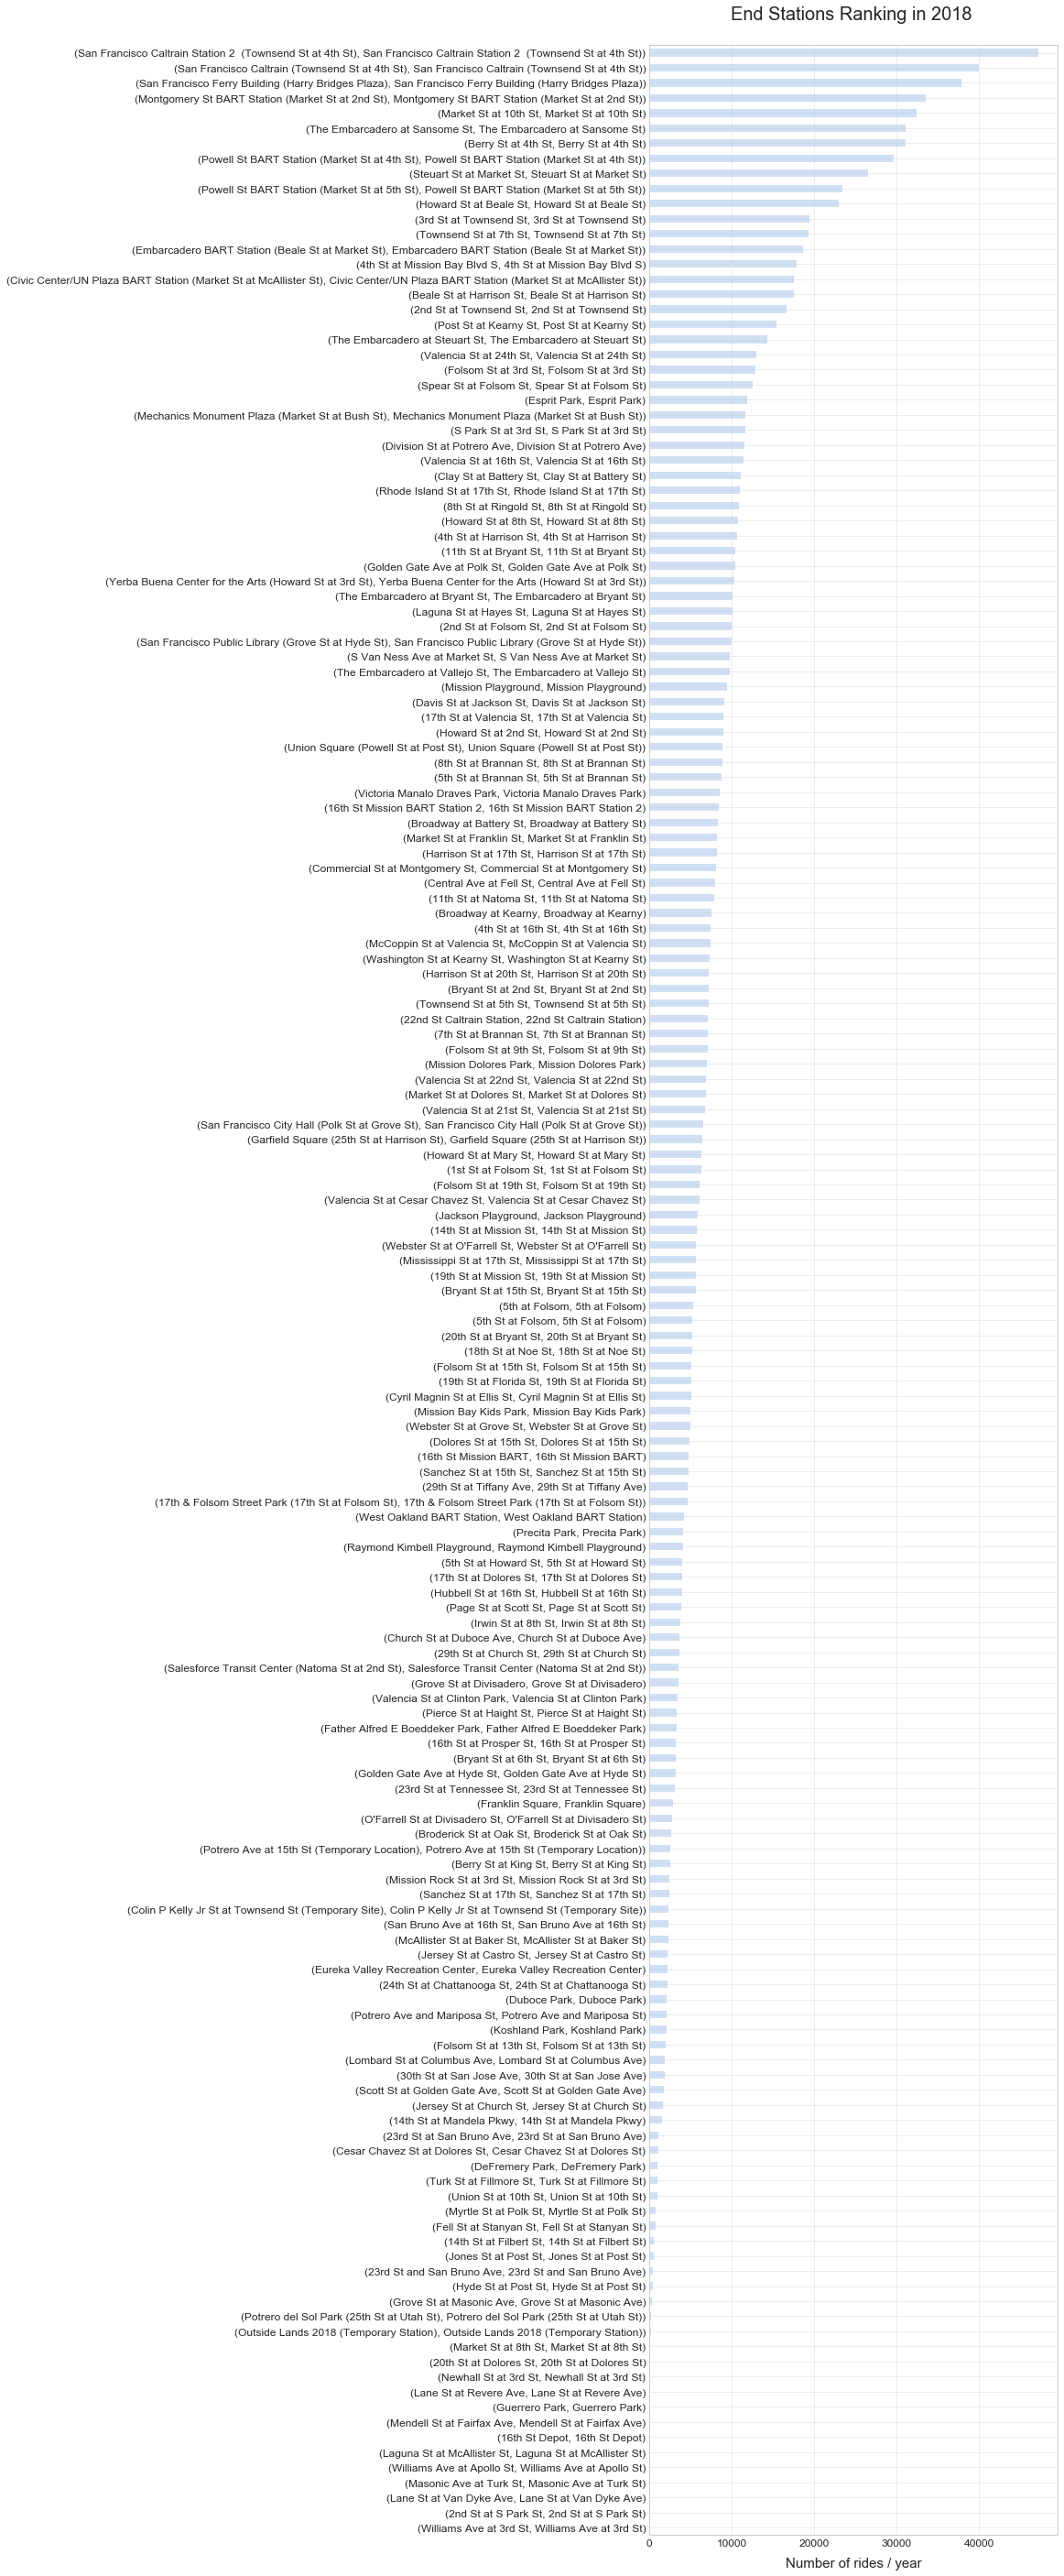

In [14]:
# plot Ranking end stations
data=rides_18_clean.groupby('end_station_name')
data['end_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, 
                                                           color = '#BCD2EE',figsize = [8,50],
                                                           alpha=0.7)

plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('End Stations Ranking in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("End Station Name").set_visible(False);

As this is a very long list of stations, I will select for both start and end stations the most and least popular ones in 2018.

### Most and Least Popular Stations in 2018

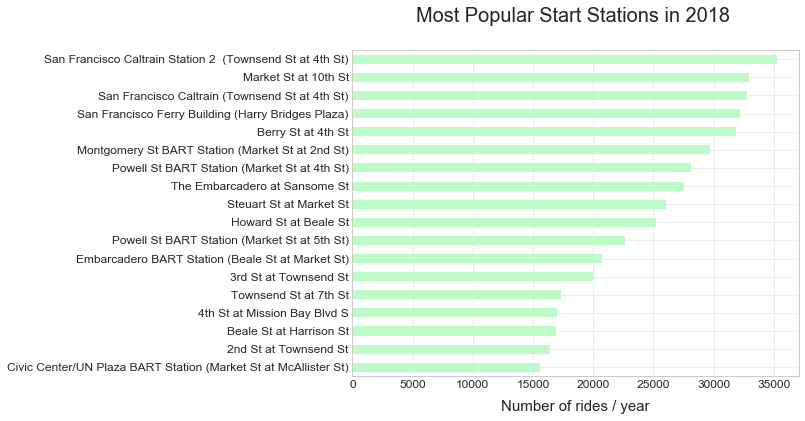

In [15]:
# plot most popular end stations

data=rides_18_clean.groupby('start_station_name').filter(lambda x: len(x) >= 15000)
data['start_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, color = '#BDFCC9',figsize = [8,6])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Most Popular Start Stations in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("End Station Name").set_visible(False);

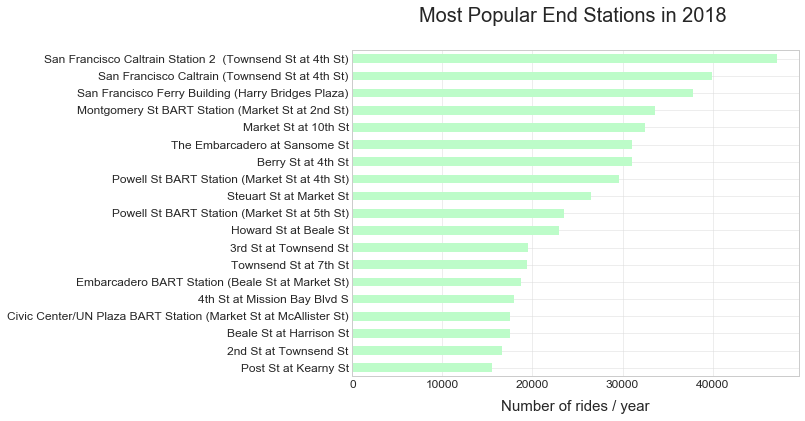

In [16]:
# plot most popular end stations

data=rides_18_clean.groupby('end_station_name').filter(lambda x: len(x) >= 15000)
data['end_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, color = '#BDFCC9',figsize = [8,6])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Most Popular End Stations in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("End Station Name").set_visible(False);

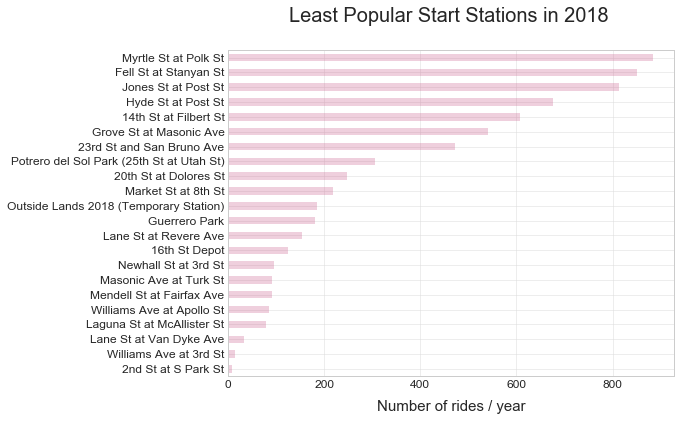

In [17]:
# plot least popular start stations
data=rides_18_clean.groupby('start_station_name').filter(lambda x: len(x) <= 1000)
data['start_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, color = '#CD6090', 
                                                             alpha=0.3, figsize = [8,6])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Least Popular Start Stations in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("Start Station Name").set_visible(False);

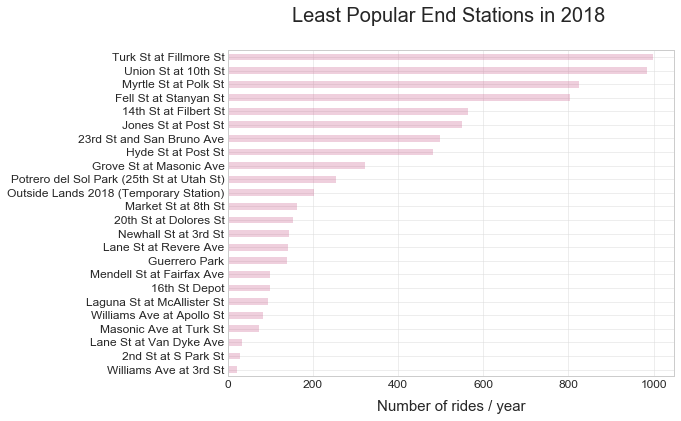

In [18]:
# plot least popular end stations
data=rides_18_clean.groupby('end_station_name').filter(lambda x: len(x) <= 1000)
data['end_station_name'].value_counts().sort_values().plot(kind = 'barh', fontsize=12, color = '#CD6090', 
                                                             alpha=0.3, figsize = [8,6])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Least Popular End Stations in 2018 \n', fontsize=20)
plt.xlabel("Number of rides / year", labelpad=10, fontsize=15)
plt.ylabel("End Station Name").set_visible(False);

**The 5 most popular start stations:**
 - San Francisco Caltrain Station 2 (Townsend St at 4th St)
 - Market St
 - San Francisco Caltrain (Townsend St at 4th St) 
 - San Francisco Ferry Building
 - Berry St at 4th St
 
**The 3 least popular start stations:**
 - 2nd St at S Park St
 - Williams Ave at 3rd St
 - Lane St at Van Dyke Ave
 

### About the features I investigated: 

Regarding the age range of the members, as can be seen in the boxplot (in the wrangling section of this project) and as explained above, members over 60 years of age are considered outliers, so, for not having possible deviations in my analysis I have decided to eliminate these records. I do not consider it a significant loss of data since it only represents 2.27% of the records.

Apart from that, I have discovered, contrary to what I believed, that more than 95% of the rides are less than one hour long. Also, there are some others that last almost 24 hours, these being minority. Thus, the new variable created (duration_hour_range) is not really usefull.

Some other curiosity is that 1.3% of the members are not identified as women or men but as other.

Due to the low frequency of rides starting or ending at less popular stations (less than 1000 rides throughout the year), it would be a good idea to study whether it is profitable to keep these stations as pick-up or drop-off points.

## Bivariate Exploration

> In this section, I investigate relationships between pairs of variables in the data.

### Monthly trend of bike rides by User Type  

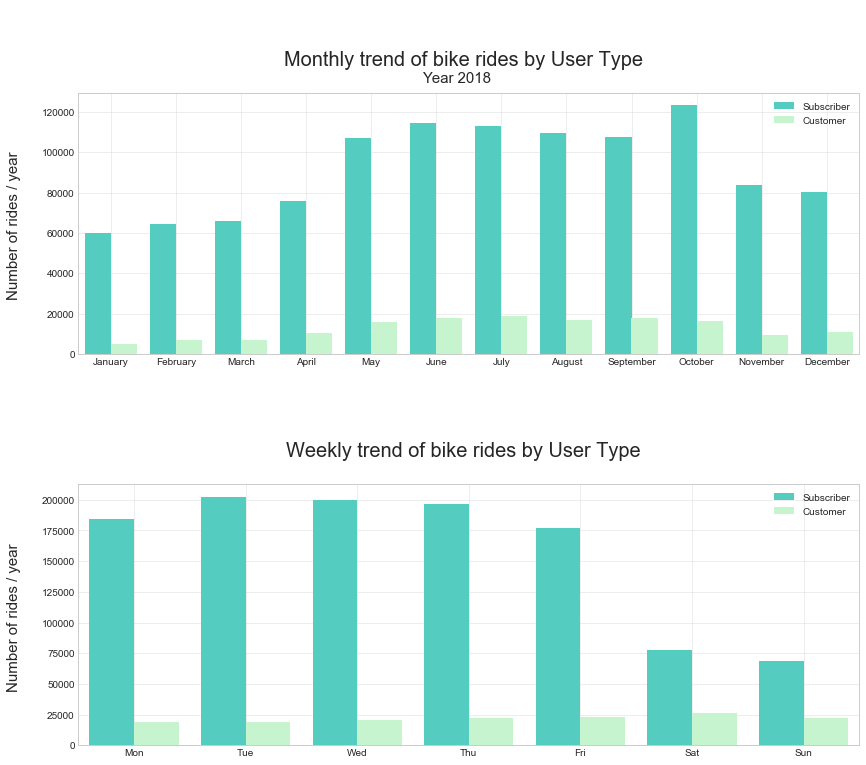

In [19]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 0.5)
ax = sb.countplot(data=rides_18_clean, x='startTime_month', hue='user_type', palette=['#40E0D0','#BDFCC9'])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Monthly trend of bike rides by User Type  \n', fontsize=20)
plt.suptitle('\n\n\n\nYear 2018',fontsize=15)
plt.xlabel('Month (2018)').set_visible(False)
plt.ylabel('Number of rides / year \n',fontsize=15)
ax.legend(loc = 1, framealpha = 1) # lower right, no transparency

plt.subplot(2, 1, 2)
ax = sb.countplot(data=rides_18_clean, x='startTime_weekday', hue='user_type',palette=['#40E0D0','#BDFCC9'])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.title('Weekly trend of bike rides by User Type  \n', fontsize=20)
plt.xlabel('weekday (2018)').set_visible(False)
plt.ylabel('Number of rides / year \n',fontsize=15)
ax.legend(loc = 1, framealpha = 1, ); # lower right, no transparency

As can be seen in the two graphs above, the number of subscribers is much higher than the number of customers. For both, the months with the highest number of riders go from May to October. For subscribers, the trend of the bars has increased in the month of October (not following the decrease trend of the bars), while for customers this does not happen as it continues to decrease.

When it comes to weekly trend, it is curious how on the weekends, for subscribers, the number of rides decreases considerably while for customers it increases slightly. This may be due to the fact that subscribers use the bike during the week to go to work and to go back home, while customers use this service on their days off to visit the city.

### Average rides Duration by gender and user type, also per month and weekday.

In [75]:
usertype_month_df = rides_18_clean.groupby(['startTime_month', 'user_type']).agg({'bike_id':'count'}).reset_index()
usertype_weekday_df = rides_18_clean.groupby(['startTime_weekday', 'user_type']).agg({'bike_id':'count'}).reset_index()

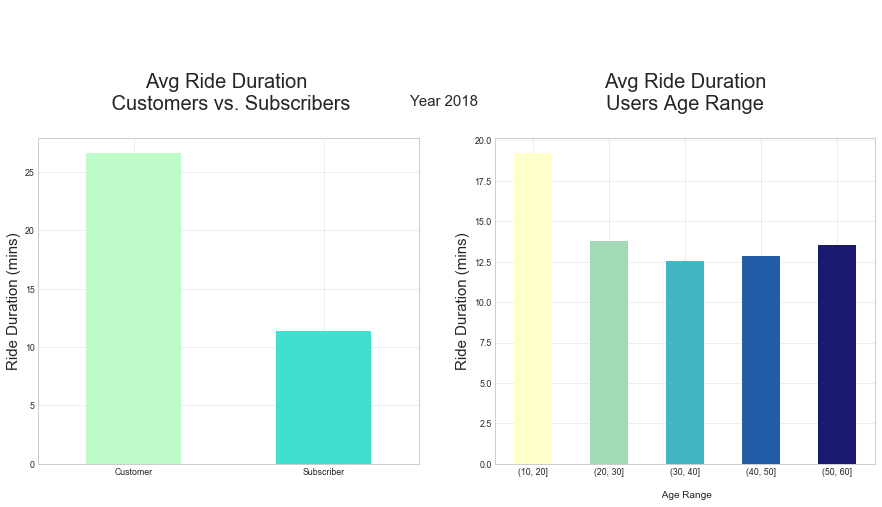

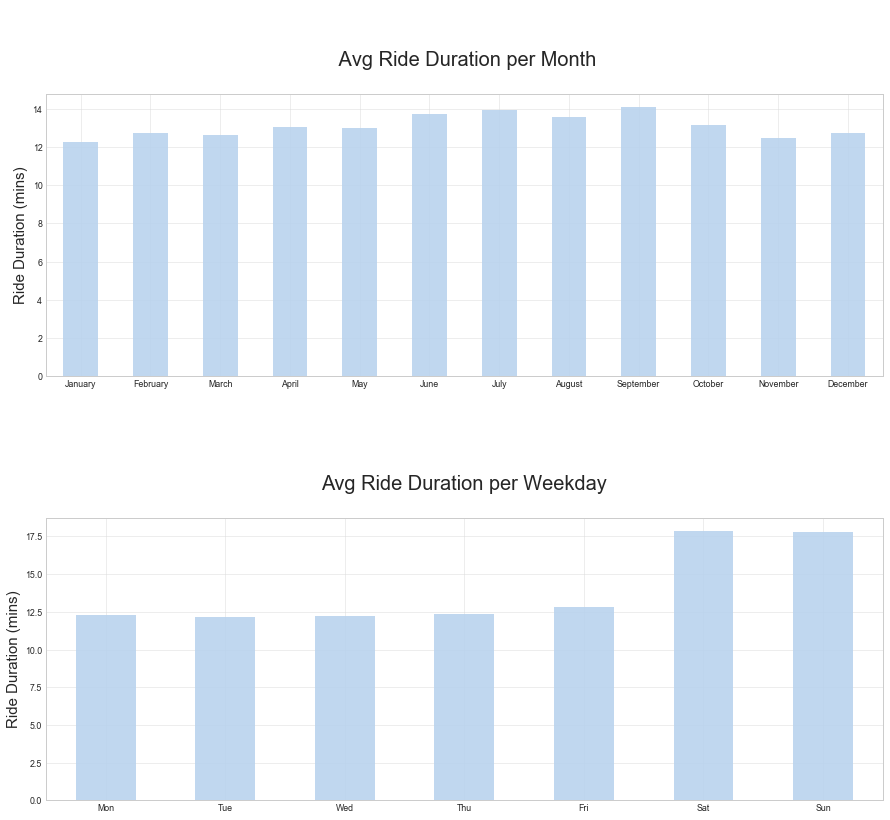

In [92]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
# Plot Avg Ride Duration vs User Type
duration_usertype = rides_18_clean.groupby('user_type')['duration_hour'].mean()*60

ax = duration_usertype.plot(kind = 'bar', color=['#BDFCC9','#40E0D0'])
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
ax.set_title('\n\n\nAvg Ride Duration \n Customers vs. Subscribers\n', fontsize = 20)
plt.suptitle('Year 2018',fontsize=15)
ax.set_ylabel('Ride Duration (mins)',fontsize=15)
ax.set_xlabel('User Type', labelpad=8).set_visible(False)
plt.xticks(rotation=360)

plt.subplot(1, 2, 2)
# Plot Avg Ride Duration vs Age range of the members
duration_age = rides_18_clean.groupby('Age_range')['duration_hour'].mean()*60

ax = duration_age.plot(kind = 'bar', color=['#ffffcc','#a1dab4','#41b6c4','#225ea8','#191970'])
ax.set_title('\n\n\nAvg Ride Duration\nUsers Age Range\n', fontsize = 20)
ax.set_ylabel('Ride Duration (mins)',fontsize=15)
ax.set_xlabel('\n Age Range', fontsize=10)
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.xticks(rotation=360)


plt.figure(figsize=(15,13))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(2, 1, 1)

# Set Age_range to category
rides_18_clean.startTime_month = rides_18_clean.startTime_month.astype('category')
# Set the order for the startTime_month variable
rides_18_clean.Age_range = rides_18_clean.Age_range.astype('category')
ordinal_month = ['January','February','March','April',
                 'May','June','July','August','September',
                 'October','November', 'December']
pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    ordered_var_ = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_month)
    rides_18_clean['startTime_month'] = rides_18_clean['startTime_month'].astype(ordered_var_)
else: # pre-v0.21
    rides_18_clean['startTime_month'] = rides_18_clean['startTime_month'].astype('category', ordered = True,
                                                                                 categories = ordinal_month)
    
# Plot Avg Ride Duration per month
duration_month = rides_18_clean.groupby('startTime_month')['duration_hour'].mean()*60

ax = duration_month.plot(kind = 'bar', color = '#B9D3EE', alpha=.9)
ax.set_title('\n\n Avg Ride Duration per Month\n', fontsize = 20)
ax.set_ylabel('Ride Duration (mins)', fontsize=15)
ax.set_xlabel('month', labelpad=8).set_visible(False)
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.xticks(rotation=360)

plt.subplot(2, 1, 2)
# Plot Avg Ride Duration per weekday
duration_weekday = rides_18_clean.groupby('startTime_weekday')['duration_hour'].mean()*60

ax = duration_weekday.plot(kind = 'bar', color = '#B9D3EE', alpha=.9)
ax.set_title('Avg Ride Duration per Weekday\n', fontsize = 20)
ax.set_ylabel('Ride Duration (mins)', fontsize=15)
ax.set_xlabel('weekday', labelpad=8).set_visible(False)
plt.grid(True, color = 'gainsboro',  linewidth=1, alpha=.5)
plt.xticks(rotation=360);

The customers rides last an average of approximately 26 minutes, while the subscribers rides last an average of 11 minutes, this may be due to the explanation given for the graph above.

The longest trips are made by young people between 10 and 20 years old, again, this might be due to the fact that these use the service to take a leisurely ride around the city and not to go to work or run errands (taking this less time). The users for whom the rides take least time are those between 30 and 40 years old.

The rides have a slightly longer duration between the months of May and October, this same trend is followed for the weekends, in which the duration of the trips increases.


### Monthly and Weekly Trend of Bike Rides by Member Age Range

In [77]:
# Set Age_range to category
rides_18_clean.Age_range = rides_18_clean.Age_range.astype('category')

In [78]:
age_month_df = rides_18_clean.groupby(['startTime_month', 'Age_range']).agg({'bike_id':'count'}).reset_index()
age_weekday_df = rides_18_clean.groupby(['startTime_weekday', 'Age_range']).agg({'bike_id':'count'}).reset_index()

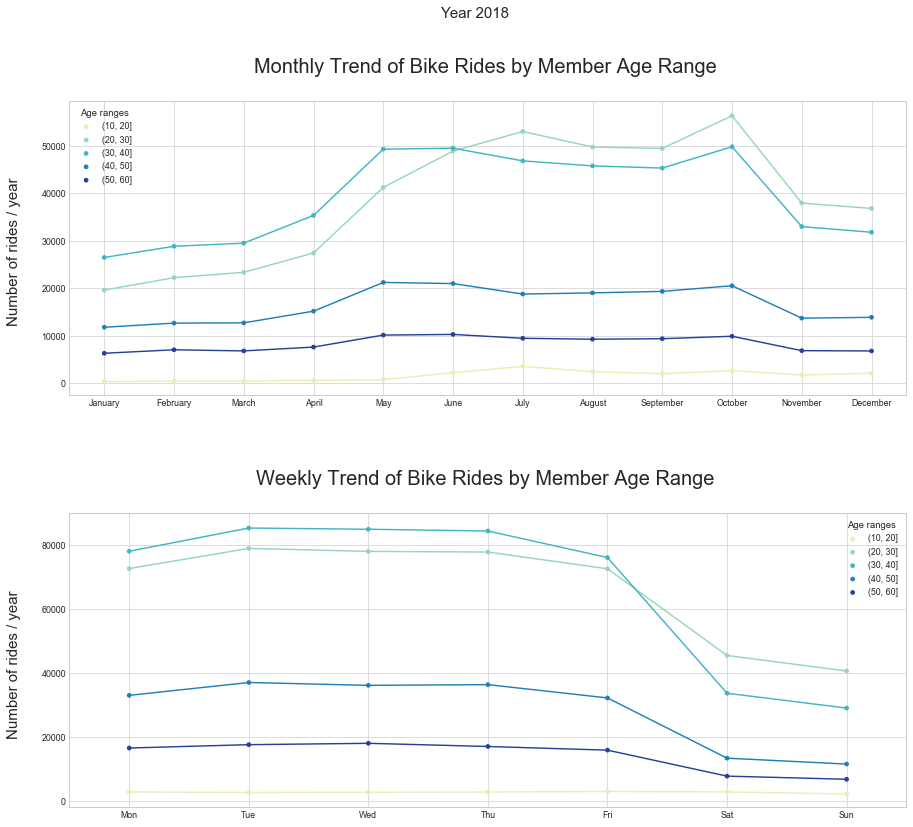

In [79]:
plt.figure(figsize=(15,13))

# create plot
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 0.4)

ax = sb.pointplot(data=age_month_df, x='startTime_month', y='bike_id', hue='Age_range',palette="YlGnBu")
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('Monthly Trend of Bike Rides by Member Age Range \n', fontsize=20)
plt.suptitle('Year 2018 ',fontsize=15)
plt.xlabel('month(2018)').set_visible(False)
plt.ylabel('Number of rides / year  \n', fontsize=15)
ax.legend(loc = 2, framealpha = 1, title='Age ranges') # lower right, no transparency

# create plot
plt.subplot(2, 1, 2)

# Set the order for the startTime_weekday variables
ordinal_var = ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun']
pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var)
    rides_18_clean['startTime_weekday'] = rides_18_clean['startTime_weekday'].astype(ordered_var)
else: # pre-v0.21
    rides_18_clean['startTime_weekday'] = rides_18_clean['startTime_weekday'].astype('category', ordered = True, categories = ordinal_var)

ax = sb.pointplot(data=age_weekday_df, x='startTime_weekday',y='bike_id', hue='Age_range',palette="YlGnBu")
plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('Weekly Trend of Bike Rides by Member Age Range \n', fontsize=20)
plt.suptitle('Year 2018',fontsize=15)
plt.xlabel('weekday').set_visible(False)
plt.ylabel('Number of rides / year  \n', fontsize=15)
ax.legend(loc = 1, framealpha = 1, title='Age ranges'); # lower right, no transparency

In these two graphs the aforementioned is shown. It can be highlighted how from April the number of riders between 20 and 40 years old increases much more sharply than for other riders, although this trend stops in May for users from 30 to 40 years old.

The number of rides decreases on weekends in a more pronounced way for users between 30 and 40 years old.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Number of Rides per Weekday and per Hour of Day for different user types

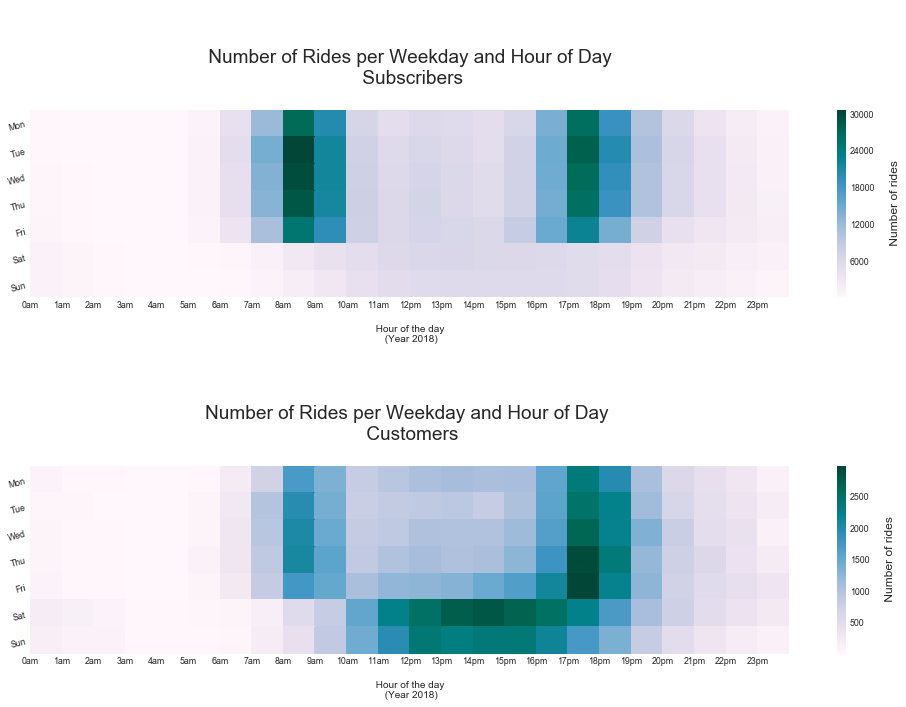

In [80]:
plt.figure(figsize=(17,10))

# plot for customers
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 0.9)

subscriber_df = rides_18_clean.query('user_type == "Subscriber"').groupby(["startTime_weekday","startTime_hour"])["bike_id"].size().reset_index()
subscriber_df = subscriber_df.pivot("startTime_weekday", "startTime_hour", "bike_id")
ax=sb.heatmap(subscriber_df, cmap="PuBuGn", cbar_kws={'label': '\n Number of rides'})
ax.figure.axes[-1].yaxis.label.set_size(12)

plt.title("\n\n Number of Rides per Weekday and Hour of Day \n Subscribers\n", fontsize=19)
plt.xlabel('\n Hour of the day \n (Year 2018)', fontsize=10)
plt.ylabel('Start Time Hour').set_visible(False)
plt.yticks(rotation=15)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am", "12pm",
                  "13pm", "14pm", "15pm", "16pm", "17pm", "18pm", "19pm", "20pm", "21pm", "22pm", "23pm"]
plt.xticks(x_ticks,x_ticks_labels)

# plot for subscribers
plt.subplot(2, 1, 2)
customer_df = rides_18_clean.query('user_type == "Customer"').groupby(["startTime_weekday","startTime_hour"])["bike_id"].size().reset_index()
customer_df = customer_df.pivot("startTime_weekday", "startTime_hour", "bike_id")
ax=sb.heatmap(customer_df, cmap="PuBuGn", cbar_kws={'label': '\n Number of rides'})
ax.figure.axes[-1].yaxis.label.set_size(12)

plt.title("Number of Rides per Weekday and Hour of Day \n Customers\n", fontsize=19)
plt.xlabel('\n Hour of the day \n (Year 2018)', fontsize=10)
plt.ylabel('Weekday').set_visible(False)
plt.yticks(rotation=15)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am", "12pm",
                  "13pm", "14pm", "15pm", "16pm", "17pm", "18pm", "19pm", "20pm", "21pm", "22pm", "23pm"]
plt.xticks(x_ticks,x_ticks_labels);

In these plots it can be seen in great detail, in terms of schedules by days of the week, the trend in the number of rides.

For subscribers: it is clear that the large volume of rides occurs at two peak hours (8am and 5pm) and this happens from Monday to Friday. During the weekend, the number of rides decreases sharply.

For customers: on the contrary, the number of rides is larger on weekends and this occurs in a distributed manner over time from 10 in the morning to approximately 7 in the afternoon. From Monday to Friday occurs something similar to what has been described for subscribers, but with a slight difference: subscribers use the bike a bit more at 8am than at 5pm, while customers ride a bit more at 5pm than at 8am.

### Members Age by Weekday and Hours of Day for different user types

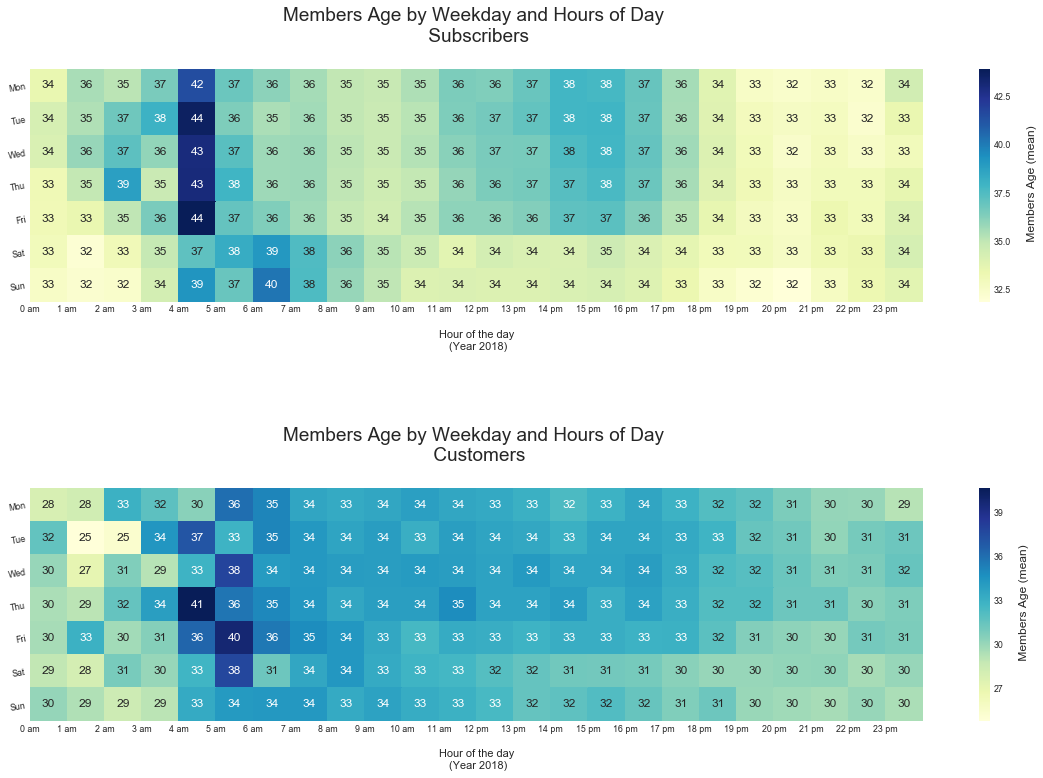

In [81]:
### Number of Rides per Weekday and Hour of Day for different user typesplt.figure(figsize=(20,12))
plt.style.use("seaborn-whitegrid")

# plot for subscribers
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = .8)

    # set dataframe
subscriber_df_ = rides_18_clean.query('user_type == "Subscriber"').groupby(["startTime_weekday","startTime_hour"])["member_age"].mean().reset_index()
subscriber_df_ = subscriber_df_.pivot("startTime_weekday", "startTime_hour", "member_age")
     # plotting
ax=sb.heatmap(subscriber_df_, cmap="YlGnBu", annot=True, 
           annot_kws={"size": 12}, cbar_kws={'label': '\n Members Age (mean)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.title("Members Age by Weekday and Hours of Day \n Subscribers\n", fontsize=19)
plt.xlabel('\n Hour of the day \n (Year 2018)',fontsize=11)
plt.ylabel('Weekday').set_visible(False)
plt.yticks(rotation=10)
plt.xticks(rotation=360)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm",
                  "13 pm", "14 pm", "15 pm", "16 pm", "17 pm", "18 pm", "19 pm", "20 pm", "21 pm", "22 pm", "23 pm"]
plt.xticks(x_ticks,x_ticks_labels)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values;

# plot for customers
plt.subplot(2, 1, 2)

    # set dataframe
customers_df_ = rides_18_clean.query('user_type == "Customer"').groupby(["startTime_weekday","startTime_hour"])["member_age"].mean().reset_index()
customers_df_ = customers_df_.pivot("startTime_weekday", "startTime_hour", "member_age")
    # plotting
ax=sb.heatmap(customers_df_, cmap="YlGnBu", annot=True, 
           annot_kws={"size": 12}, cbar_kws={'label': '\n Members Age (mean)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.title("Members Age by Weekday and Hours of Day \n Customers\n", fontsize=19)
plt.xlabel('\n Hour of the day \n (Year 2018)',fontsize=11)
plt.ylabel('Weekday').set_visible(False)
plt.yticks(rotation=10)
plt.xticks(rotation=360)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm",
                  "13 pm", "14 pm", "15 pm", "16 pm", "17 pm", "18 pm", "19 pm", "20 pm", "21 pm", "22 pm", "23 pm"]
plt.xticks(x_ticks,x_ticks_labels)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

In these graphics, a fact that has caught my attention stands out for its color. On average, the users who take the bicycle at 4am are people around 43 years old. This fact is strange to me since I was expecting this same result for a user between 20 and 30 years old going back home from a night out.

It also highlights how the public is younger for the subscriber type of user.

### Rides Duration by Members Age ranges and Month for different user types

In [82]:
# Create a new column for ride duration in minutes
rides_18_clean['duration_min']=rides_18_clean['duration_hour']*60

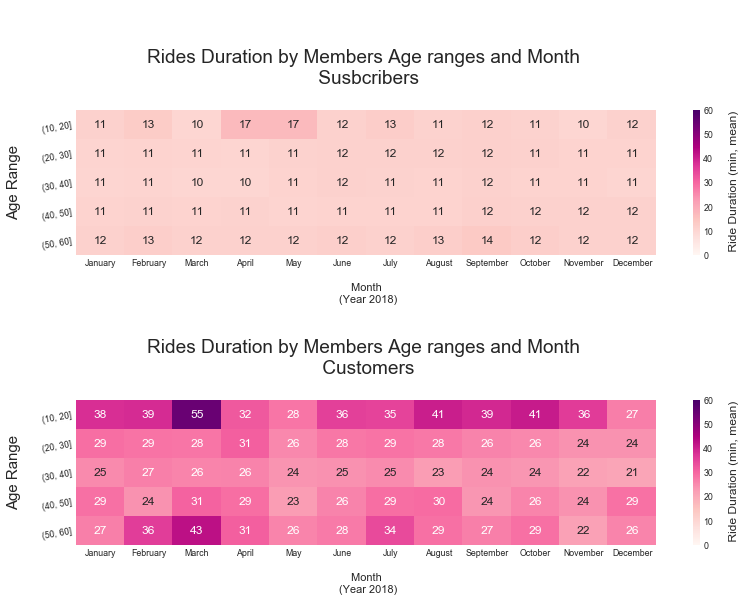

In [91]:
plt.figure(figsize=(13,8))
plt.style.use("seaborn-whitegrid")

# plot for subscribers
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 1)

# set dataframe
subscriber_df_ = rides_18_clean.query('user_type == "Subscriber"').groupby(["Age_range","startTime_month"])["duration_min"].mean().reset_index()
subscriber_df_ = subscriber_df_.pivot("Age_range", "startTime_month", "duration_min")
    # plotting
ax=sb.heatmap(subscriber_df_, cmap="RdPu", annot=True,
              annot_kws={"size": 12}, cbar_kws={'label': '\n Ride Duration (min, mean)'},
              vmin=0, vmax=60)
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.title("\n\nRides Duration by Members Age ranges and Month \n Susbcribers\n", fontsize=19)
plt.xlabel('\n Month \n (Year 2018)',fontsize=11)
plt.ylabel('Age Range\n',fontsize=15)
plt.yticks(rotation=10)
plt.xticks(rotation=360)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values;

# plot for customers
plt.subplot(2, 1, 2)

    # set dataframe
customers_df_ = rides_18_clean.query('user_type == "Customer"').groupby(["Age_range","startTime_month"])["duration_min"].mean().reset_index()
customers_df_ = customers_df_.pivot("Age_range", "startTime_month", "duration_min")
    # plotting
ax=sb.heatmap(customers_df_, cmap="RdPu", annot=True, 
           annot_kws={"size": 12}, cbar_kws={'label': '\n Ride Duration (min, mean)'},
              vmin=0, vmax=60)
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.title("Rides Duration by Members Age ranges and Month \n Customers\n", fontsize=19)
plt.xlabel('\n Month \n (Year 2018)',fontsize=11)
plt.ylabel('Age Range\n',fontsize=15)
plt.yticks(rotation=10)
plt.xticks(rotation=360)


b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) value

As previously discussed, for the study year (2018), the rides duration range is longer for subscribers than for customers.

For subscribers: The highest average duration of rides by age range and by month was given for users between 10 and 20 years old in the months of April and May.

For subscribers: The highest average duration of rides by age range and by month was given for users between 10 and 20 years old in March. The lowest average duration took place in December for users between 30 and 40 years old.

### Start Station vs. Start hour Ride for Customers & Subscribers

In [87]:
# Create most popular start stations dataframe
rides_18_clean_sub = rides_18_clean.groupby('start_station_name').filter(lambda x: len(x) >= 15000)

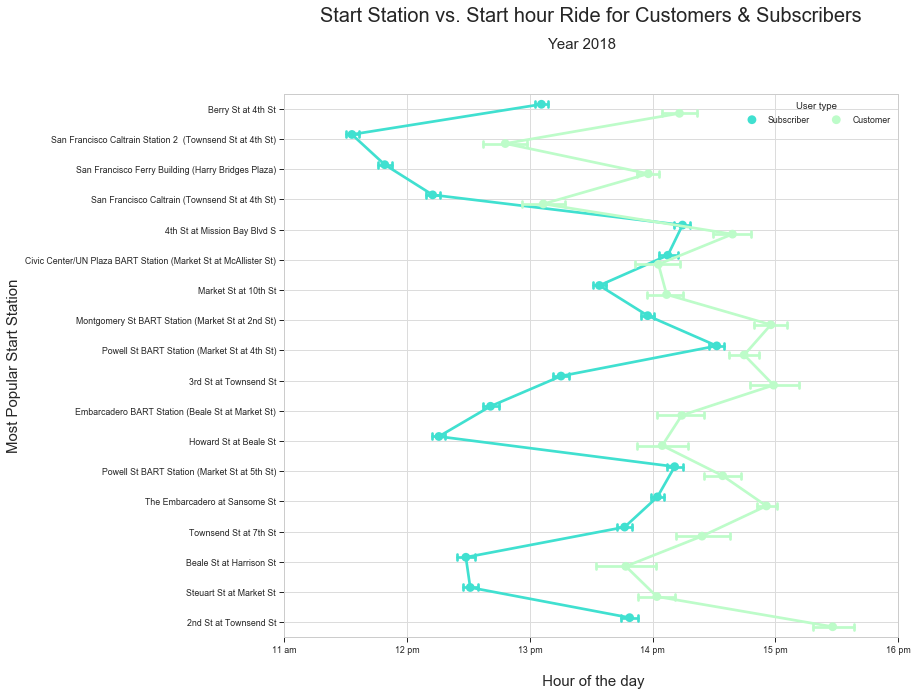

In [88]:
fig = plt.figure(figsize = [11,10])
paper_rc = {'lines.linewidth': 1.5}                  
sb.set_context("paper", rc = paper_rc)

ax = sb.pointplot(data = rides_18_clean_sub, x= 'startTime_hour', y = 'start_station_name', hue ='user_type', 
                  palette=['#40E0D0','#BDFCC9'], dodge = 0.3, linestyles = "-", join=True,capsize=.2)

plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('Start Station vs. Start hour Ride for Customers & Subscribers\n\n\n', fontsize=20)
plt.suptitle('\nYear 2018',fontsize=15)
plt.xlabel('\n Hour of the day', fontsize=15)
plt.ylabel('Most Popular Start Station', fontsize=15)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm",
                  "13 pm", "14 pm", "15 pm", "16 pm", "17 pm", "18 pm", "19 pm", "20 pm", "21 pm", "22 pm", "23 pm"]
plt.xticks(x_ticks,x_ticks_labels)

plt.xlim(11,16)
ax.legend(ncol = 3, title='User type');

Here a clear trend between subscribers and customers can be differentiated in all of the most popular stations. Subscribers always take the bike an average of an hour earlier than customers. 

In my opinion, this is a good practice since, this way, the system ensures that its most loyal customers (the subscribers) are provided with bicycles with greater certainty.

### Most Popular Routes by Members Age

In [85]:
rides_18_clean_sub.startTime_quarter = rides_18_clean_sub.startTime_quarter.astype('category')

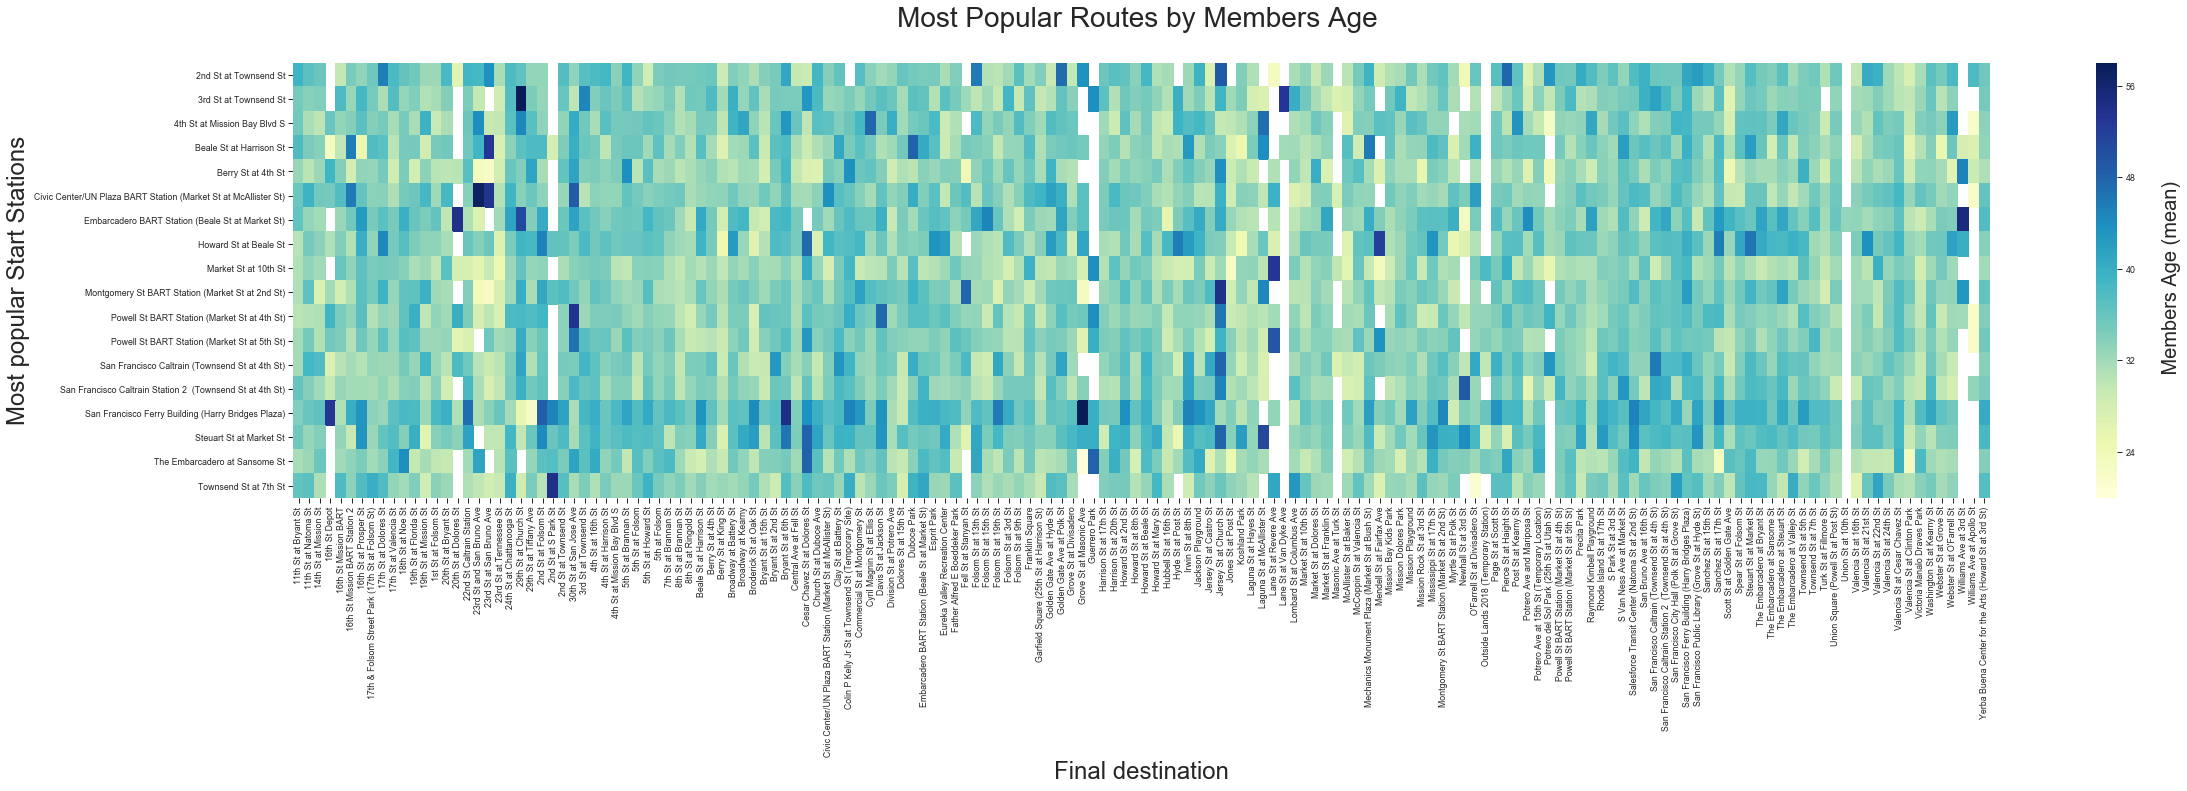

In [90]:
plt.figure(figsize=(38,8))

    # Set data
routes_age = rides_18_clean_sub.groupby(['end_station_name', 'start_station_name']).mean()['member_age']
routes_age = routes_age.reset_index(name = 'members_age_avg')
routes_age = routes_age.pivot(index = 'start_station_name', columns = 'end_station_name', values = 'members_age_avg')
    
    # plotting
ax=sb.heatmap(routes_age, cmap="YlGnBu", cbar_kws = {'label' : '\n Members Age (mean)'})
plt.title('Most Popular Routes by Members Age \n', fontsize=28)
plt.xlabel('Final destination', fontsize=24)
plt.ylabel('Most popular Start Stations', fontsize=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values;

For this graph, it does not make sense to detail in this paragraph each one of the routes that are mostly traveled by people of older or younger age, but it can be very useful when studying pricing strategies by station or types of bikes in each specific station depending on the user's income level or physical condition. Also to make sure there are always bikes availables for these routes in terms of logistic strategy.

### Start Station vs. Start hour Ride by Year Quarter

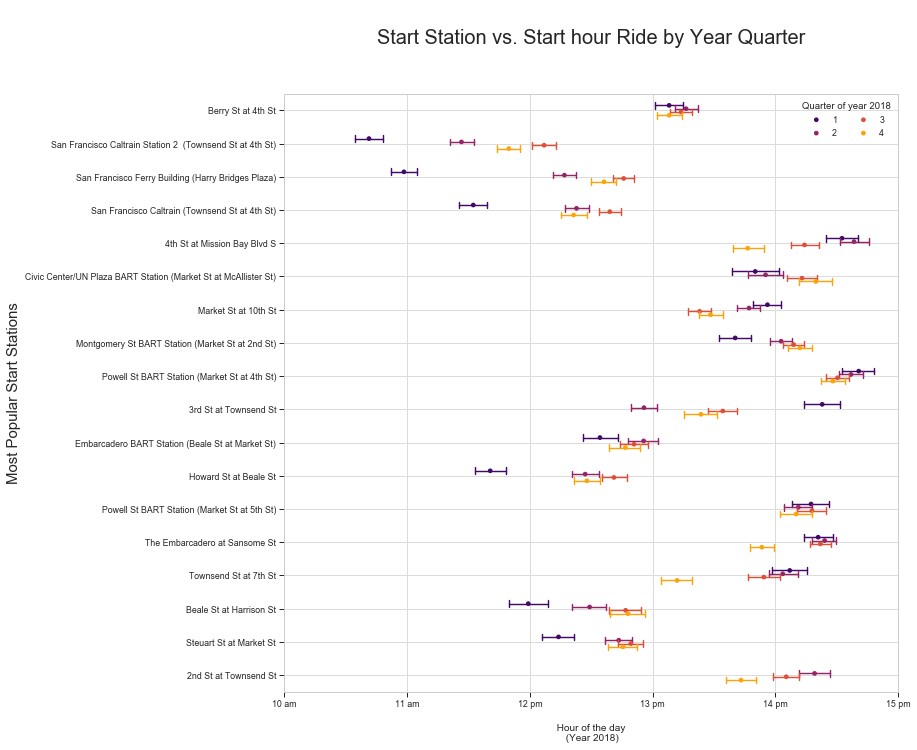

In [86]:
fig = plt.figure(figsize = [11,11])
paper_rc = {'lines.linewidth': .8}                  
sb.set_context("paper", rc = paper_rc)

ax = sb.pointplot(data = rides_18_clean_sub, x= 'startTime_hour', y = 'start_station_name', hue ='startTime_quarter', 
                  palette=['#410967', '#932567', '#DC5039', '#FBA40A'], dodge = 0.3, linestyles = "", join=True,capsize=.2)

plt.grid(True, color = 'gainsboro',  linewidth=1)
plt.title('\nStart Station vs. Start hour Ride by Year Quarter\n\n', fontsize=20)
plt.xlabel('\n Hour of the day \n (Year 2018)', fontsize=10)
plt.ylabel('Most Popular Start Stations', fontsize=15)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
x_ticks_labels = ["0 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm",
                  "13 pm", "14 pm", "15 pm", "16 pm", "17 pm", "18 pm", "19 pm", "20 pm", "21 pm", "22 pm", "23 pm"]
plt.xticks(x_ticks,x_ticks_labels);

plt.xlim(10,15)
ax.legend(ncol = 2, title='Quarter of year 2018');

In this graph I have found it curious how for some stations the average start time for rides differs more than an hour depending on the year quarter and for other stations the average start time for the rides is almost the same for each quarter of the year.

Again, this graph would be useful if a specific strategy for a specific station would wanted to be developed.

## Sources
- https://github.com/burakgunbatan/UdacityProject---CommunicateDataFindings/blob/master/Exploration_Ford_GoBike_BurakGunbatan.ipynb
- https://stackoverflow.com/questions/6159074/given-the-lat-long-coordinates-how-can-we-find-out-the-city-country
- https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://github.com/mwaskom/seaborn/issues/1773

